<font size=6><b>Producing a Functional Connectivity Map 

This notebook explains what a functional connectivity map is and explains how to construct one, given a curated dataset. 

In [2]:
import pickle

In [1]:
from human_hip.spike_data import plot_functional_connectivity_map

plot_functional_connectivity_map( sd, latency_threshold=.2, show_sttc=True,  sttc_threshold=.2)

In [3]:
with open('/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/sd_ca1_curated.pkl', "rb") as my_file:
    sd = pickle.load(my_file)

calculating all latencies...
making plot


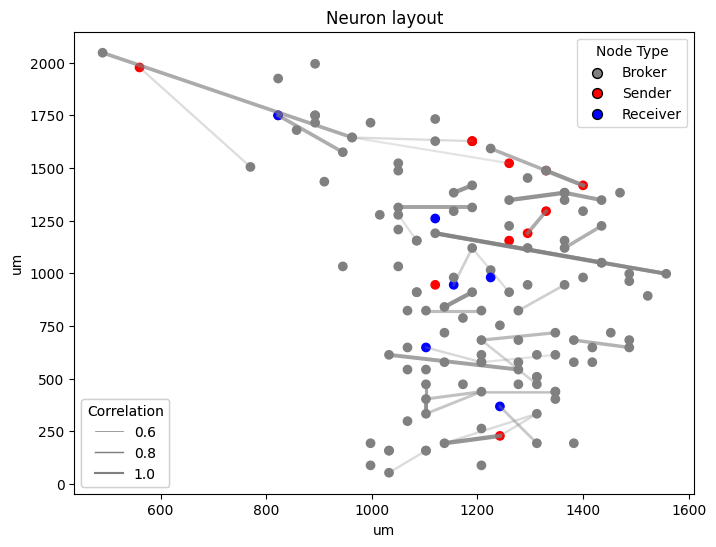

In [5]:
plot_functional_connectivity_map( sd )

In [8]:
import matplotlib.pyplot as plt


def latencies_mean_neuron(lat_list):
    """
    Output: Returns a list containing the mean latencies for each sublist.
    Input: lat_list- A list of lists representing latencies between a particular neuron, x, and all others. Created with `sd.latencies_to_index(x)`
    """
    nested_list = lat_list
    for i in range(len(nested_list)):
        sublist = nested_list[i]
        length = len(sublist)
        if length == 0:
            sublist_mean = 0
        else:
            sublist_mean = sum(sublist)/len(sublist)
            sublist_mean = round(sublist_mean, 3) # Round to 3d.p.
        nested_list[i] = sublist_mean
    return nested_list



def latencies_mean_all(sd):
    """
    Output: Returns a list of lists containing the mean latencies between all neurons
    Input: sd- A SpikeData object, the standard data format for braingeneers
    """
    latencies_array = [None] * sd.N
    for curr_neuron in range(sd.N):
        latencies = latencies_mean_neuron(sd.latencies_to_index(curr_neuron))
        latencies_array[curr_neuron] = latencies # Store mean latency in corresponding position of 'latencies_array2'
    return latencies_array



def get_in_out_degree( mean_latency_matrix ): 
    """
    Output: Returns a list of tuples, [(incoming,outgoing),....] , containing the in and out degree for each neuron. 
            This is the number of "receicer" and "sender" signals the neurons get from other neurons
    Input: mean_latency_matrix- A list of lists containing the mean latency between all neurons
    """
    in_out_deg = [(0, 0) for _ in range(len(mean_latency_matrix))]
    for curr_neuron in range(len(mean_latency_matrix)):
        in_deg = 0
        out_deg = 0
        curr_neural_latencies = mean_latency_matrix[curr_neuron]
        for i in range(len(curr_neural_latencies)):
            if curr_neural_latencies[i] > 0:
                out_deg += 1
            if curr_neural_latencies[i] < 0:
                in_deg += 1
        in_out_deg[curr_neuron] = (in_deg, out_deg)
    return in_out_deg 



def label_sender_receiver_neurons(in_out_deg, latency_thresh=0.2):
    """
    Output: Returns a list with values ""grey", "red", "blue" representing whether a neuron is a "broker", "sender" or "receiver" respectively
    Inputs:
        in_out_deg- A list of tuples, [(incoming,outgoing),....] , containing the number of in/out signals for each neuron.
        latency_thresh- A float between 0-1. The threshold for the fraction of in/out signals a neuron must have to be labelled a "sender" or "receiver"
    """
    # Nodes with high fraction of outgoing edges labelled 'sender' - 'red'
    # Nodes with high fraction of incoming edges labelled 'receiver' - 'blue'
    # Nodes with no high fraction are labelled `broker` - 'grey'
    # Threshold is set to 0.2 - in Tal Sharf paper this is 0.8
    node_info = ['grey'] * len(in_out_deg)
    for i in range(len(in_out_deg)):
        test1 = (in_out_deg[i][1] - in_out_deg[i][0]) / (in_out_deg[i][1] + in_out_deg[i][0])
        test2 = (in_out_deg[i][0] - in_out_deg[i][1]) / (in_out_deg[i][1] + in_out_deg[i][0])
        # node_info[i] = (test1, test2)
        if test1 > latency_thresh:
            node_info[i] = 'red'
        if test2 > latency_thresh:
            node_info[i] = 'blue'
    return node_info # Returns a list of strings



In [9]:

# Plot functional connectivity map
print("calculating all latencies...")
all_mean_latencies = latencies_mean_all(sd)


calculating all latencies...


In [28]:

latency_threshold=.1
show_sttc=True
sttc_threshold=.4


In [29]:
in_out_deg = get_in_out_degree(all_mean_latencies)
sender_receiver_neurons = label_sender_receiver_neurons(in_out_deg, latency_threshold )

making plot


/tmp/ipykernel_28305/3440654206.py:4: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():
/tmp/ipykernel_28305/3440654206.py:28: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  ix,iy = sd.neuron_data[0][i]['position']
/tmp/ipykernel_28305/3440654206.py:29: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  jx,jy = sd.neuron_data[0][j]['position']


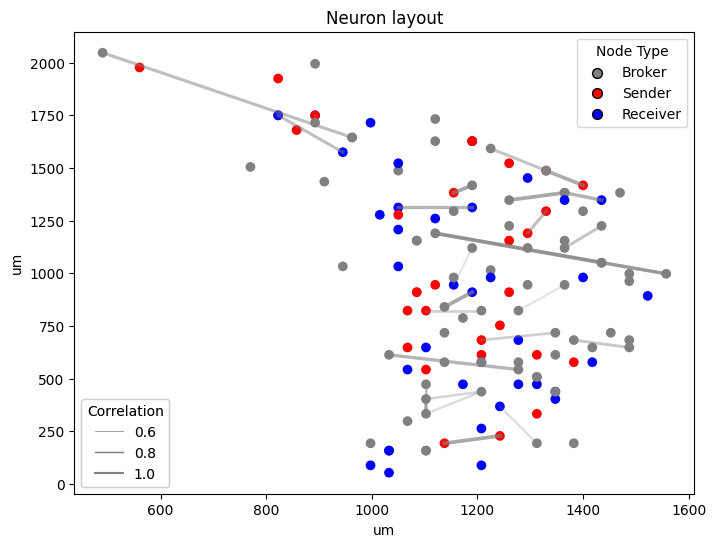

In [30]:

print("making plot")
neuron_x = []
neuron_y = []
for neuron in sd.neuron_data[0].values():
    neuron_x.append(neuron['position'][0])
    neuron_y.append(neuron['position'][1])
plt.figure(figsize=(8,6))
plt.scatter(neuron_x, neuron_y, c=sender_receiver_neurons)

node_type_legend_elements = [
plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='grey', label='Broker'),
plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='red', label='Sender'),
plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='blue', label='Receiver')
]
node_type_legend = plt.legend(handles=node_type_legend_elements, title='Node Type', loc='best')
plt.gca().add_artist(node_type_legend)
plt.title("Neuron layout")
plt.xlabel('um')
plt.ylabel('um')

# Plot spike tim tiling connections between neurons
if show_sttc:
    sttc = sd.spike_time_tilings()
    for i in range(sttc.shape[0]):
        for j in range(sttc.shape[1]):
            if i <= j: continue
            if sttc[i,j] < sttc_threshold : continue
            ix,iy = sd.neuron_data[0][i]['position']
            jx,jy = sd.neuron_data[0][j]['position']
            linewidth = 1.5 + 2 * (sttc[i, j] - sttc_threshold)
            opacity = 0.2 + 0.8 * (sttc[i, j] - sttc_threshold)  # Modify opacity based on correlation
            # Plot line between the points with linewidth and opacity
            plt.plot([ix, jx], [iy, jy], linewidth=linewidth, c='grey', alpha=opacity)

    correlation_legend_elements = [
        plt.Line2D([0], [0], color='grey', linewidth=0.5, label='0.6'),
        plt.Line2D([0], [0], color='grey', linewidth=1.0, label='0.8'),
        plt.Line2D([0], [0], color='grey', linewidth=1.5, label='1.0')
    ]
    correlation_legend = plt.legend(handles=correlation_legend_elements, title='Correlation', loc='lower left')
    plt.gca().add_artist(correlation_legend)

plt.show()


# Introduction

## What is a Functional Connectivity Map?

A functional connectivity map visualizes the pairwise correlation strength between the activities or spike trains of different neural units within a neural network or brain circuit. A FCM provides a representation of the statistical dependencies or synchronization patterns between these units, revealing how they communicate and interact with each other.

## What is the value of a Functional Connectivity Map?

Functional connectivity maps provide a valuable tool for the investigation of the organisation and internal dynamics of the brain (and cerebral organoids), facilitating our understanding of cognition, neurological disorders and neural networks. In particular, FCMs enable us to characterize and analyze the connectivity patterns in live brain tissue, a cererbral organoid, or an artificial neural network. As demonstrated later in the notebook, they provide a way to identify to key units that act as hubs, or are highly connected. More broadly, they can provide insights into the strength and directionality of connections between different regions.

# Method

## Importing data

As an example, we will use a curated dataset from an experiment conducted on live human brain tissue, recorded by a Maxwell MaxOne multi-electrode-array (MEA).

First, let us import the necessary libraries and packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import braingeneers.data.datasets_electrophysiology as ephys
from scipy.ndimage import gaussian_filter1d
import pickle


 The curated dataset is imported as a braingeneers "SpikeData" object, saved as "sd":

In [2]:
with open('/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/sd_ca1_curated.pkl', "rb") as my_file:
    sd = pickle.load(my_file)

## Exploring dataset

We can explore the dataset as follows to get a basic picture of what we are dealing with.

First, we can take a look at the metadata:

In [3]:
metadata = ephys.load_metadata('2023-04-02-hc328_rec')
print(metadata)

{'notes': 'first time hckcr1 inhibitory opsin worked on hc', 'timestamp': '2023-04-02T14:25:33', 'uuid': '2023-04-02-hc328_rec', 'ephys_experiments': {'experiment7': {'blocks': [{'num_frames': 1096400, 'path': 'original/data/2023_04_02_hc328_0.raw.h5'}], 'hardware': 'Maxwell', 'name': 'experiment7', 'notes': '', 'num_channels': 1028, 'sample_rate': 20000, 'scaler': 1, 'timestamp': '2023-04-02T4:09:26', 'units': 'µv', 'version': 20160704, 'mapping': [[0, 18964, 770.0, 1505.0], [1, 13714, 1295.0, 1085.0], [2, 12160, 1050.0, 962.5], [3, 17446, 1155.0, 1382.5], [4, 11504, 1120.0, 910.0], [5, 15030, 1225.0, 1190.0], [6, 11942, 1085.0, 945.0], [7, 16582, 1435.0, 1312.5], [8, 11710, 875.0, 927.5], [9, 17008, 1190.0, 1347.5], [10, 19408, 840.0, 1540.0], [11, 17442, 1085.0, 1382.5], [12, 9963, 1102.5, 787.5], [13, 16566, 1155.0, 1312.5], [14, 12388, 1190.0, 980.0], [15, 17884, 1120.0, 1417.5], [16, 19848, 840.0, 1575.0], [17, 16562, 1085.0, 1312.5], [18, 17650, 875.0, 1400.0], [19, 15918, 1365.

We can then identify the number of neurons, and the length of the spike train by calling on the attributes of the spike data object.

In [4]:
num_neurons = sd.N
length_spike_train = sd.length

print("Number of neurons: ", num_neurons)
print("Length of spike train in seconds: ", length_spike_train)

Number of neurons:  136
Length of spike train in seconds:  385238.05


We can also produce plots several plots including the spike raster, interspike interval and correlation matrix to provide a useful visual overview of our dataset.

In [5]:
def plot_raster(sd):
    idces, times = sd.idces_times()
    fig, ax = plt.subplots()

    ax.scatter(times/1000,idces,marker='|',s=1)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    plt.show()
    
def interspike(sd):
    # Interspike-intervals of 2 select neurons
    isis_raw = sd.interspike_intervals()
    # Remove all isi's greater than 100ms. As there are likely neurons not following periodic firing pattern
    isis=[]
    for i in range(len(isis_raw)):   
        isi=isis_raw[i]
        isis = isis + isi[isi<100].tolist() 
        
    # Plot the isi's
    plt.xlim(0,100)
    plt.hist(isis, bins=50)
    plt.xlabel('Time bin(ms)')
    plt.ylabel('ISI count')
    plt.show()
    
def correlation(sd):
    # Correlation
    corr = np.zeros((sd.N,sd.N)) #inds by inds

    dense_raster = sd.raster(bin_size=1) # in ms
    sigma = 5                            # Blur it
    dense_raster = gaussian_filter1d(dense_raster.astype(float),sigma=sigma) 
    corr=np.corrcoef( dense_raster )
    
    plt.imshow(corr)
    plt.xlabel("Neuron index")
    plt.ylabel("Neuron index")
    plt.show()
    
def raster_analysis(sd, seconds=20):
    # Zoomed Raster and pop rate
    # Get coordinates for raster
    idces, times = sd.idces_times()

    # Get population rate for everything
    pop_rate = sd.binned(bin_size=1)# in ms
    # Lets smooth this to make it neater
    sigma = 5
    pop_rate_smooth = gaussian_filter1d(pop_rate.astype(float),sigma=sigma) 
    t = np.linspace(0,sd.length,pop_rate.shape[0])/1000

    fig, ax = plt.subplots()

    ax.scatter(times/1000,idces,marker='|',s=1)
    ax2 = ax.twinx()
    ax2.plot(t,pop_rate_smooth,c='r')

    ax.set_xlim(0,seconds)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    ax2.set_ylabel('Firing Rate')
    plt.show()
    
def plot_rates(sd):
    rates = sd.rates()
    plt.hist(rates, bins=50)
    plt.xlabel('Firing rate, Hz')
    plt.ylabel('Number neural units')
    plt.show()

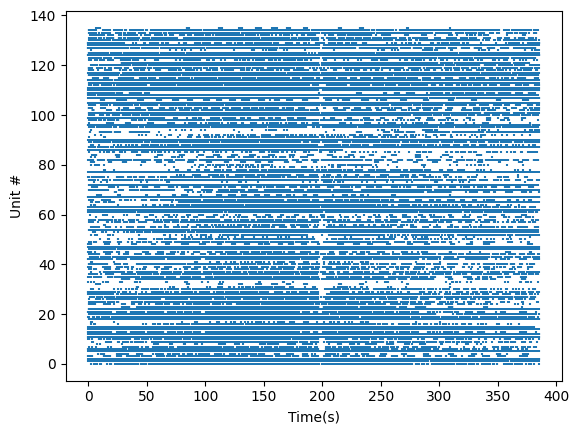

In [6]:
plot_raster(sd)

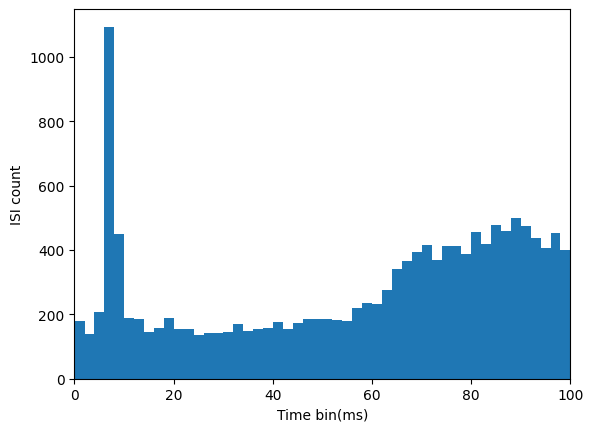

In [7]:
interspike(sd)

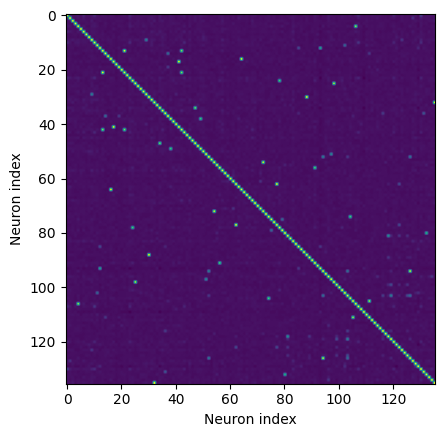

In [8]:
correlation(sd)

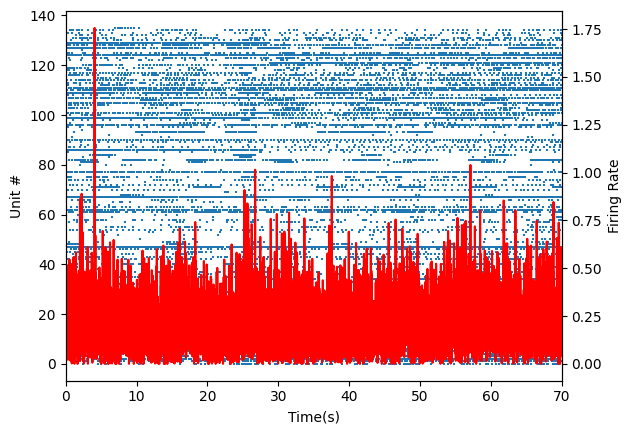

In [9]:
raster_analysis(sd, 70)

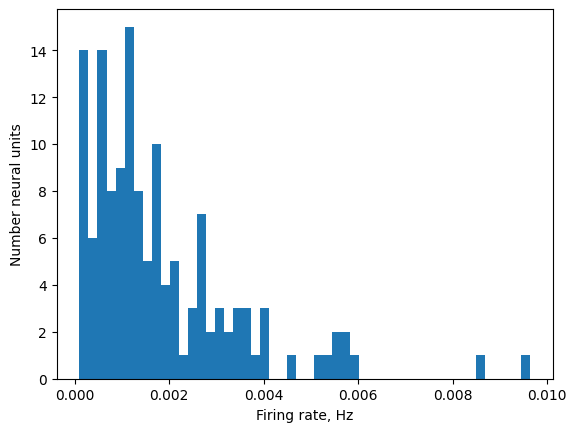

In [10]:
plot_rates(sd)

## Pairwise Correlation Calculation

To assess the degree of connectivity between two neurons (or neural units), we calculate the Spike Time Tiling Coefficient. STTC is a measure that indicates the extent to which these neurons or neural units fire together. It is a similar measure to the standard Pearson correlation coefficient, except with values [0,1] rather than [-1,1]. A value of 1 indicates perfect spike synchronization between the two units, while a value of 0 indicates random spike timing between the two units.

## Spike Time Latency Explanation and Implementation

The "Spike Time Latency" or "Latency" for short is a measure of the duration of time between the spike of one neuron, nA, and the closest occuring spike in another neuron, nB. Looking at the distribution of these latency values can give us understanding of the direction of information flow between the two neurons. For instance, if nA consistently fires before nB, we can infer that information is moving from nA to nB - this will be a positive latency measurement. If it were the case that nB was consistently firing before nA, this measure would be negative, indicating that information was flowing from nB to nA. 

Our dataset has an attribute "latencies_to_index(neuron)" that returns a 2D list, where each row is a list of latencies per neuron. For instance, if "neuron" is the first neuron of our dataset, the "latencies_to_index(neuron1)" will return a 2D list, where each sublist is a list of the latencies between neuron1 and the neuron at that index. You will notice that the length of this list will be equal to the number of neurons in the dataset - see below.

In [11]:
len(sd.latencies_to_index(0)) == sd.N

True

We want to label the neurons on our connectivity map as senders, receivers and brokers (where the neuron does not have a tendency towards sending or receiving information). To do this, we need to identify whether each neuron sends or receives information in general. Let us create a function to take a 2D list created by "latencies_to_index" and return a list of the same length, but with each sublist replaced by a single mean "latency" value.

In [12]:
# Given a list of lists representing latencies, calculate the mean latency for each sublist.
# Returns a list containing the mean latencies for each sublist.
def latencies_mean(lat_list):
    nested_list = lat_list
    for i in range(len(nested_list)):
        sublist = nested_list[i]
        length = len(sublist)
        if length == 0:
            sublist_mean = 0
        else:
            sublist_mean = sum(sublist)/len(sublist)
            sublist_mean = round(sublist_mean, 3) # Round to 3d.p.
        nested_list[i] = sublist_mean
    return nested_list

Now we want to create a "latencies" array, where the rows and columns represent the neurons, and the values filling the array represent the mean latency between the spikes of the row neuron and the column neuron. Bear in mind that for a large number of neurons, this code might take some time to run.

In [13]:
# Calculate the mean latency for each neuron and store in a 'latencies_array'
num_neurons = sd.N
latencies_array = [None] * num_neurons
for curr_neuron in range(num_neurons):
    latencies = latencies_mean(sd.latencies_to_index(curr_neuron))
    latencies_array[curr_neuron] = latencies # Store mean latency in corresponding position of 'latencies_array2'

Note that when we print this array out below, the values at latencies_array[x][x] will be 0.0, because the mean latency between a neuron and itself is 0.

In [14]:
print("Latencies array")
print(latencies_array)

Latencies array
[[0.0, -2.739, -1.464, 3.428, 9.827, 0.476, -4.234, 3.822, 0.994, 2.719, 13.726, -1.692, 1.929, 1.06, 0.198, -3.752, -0.978, -8.434, 0.386, 6.761, 1.013, 1.38, -3.905, 5.993, 1.605, 4.698, -0.507, 1.169, 0.812, 12.404, 5.802, 10.051, 0.441, 1.678, -6.222, -0.594, -4.608, -1.055, 0.409, -0.343, -0.496, -8.421, 1.936, 12.504, -1.752, 6.708, 0.564, -5.819, -3.436, 0.484, -1.711, -13.685, -2.372, 0.123, -1.112, -1.707, -2.674, 3.746, 2.041, 5.148, -6.571, 3.452, -2.69, -2.876, -1.426, 4.533, 0.263, 0.403, 11.039, 0.379, 3.604, 2.692, -1.268, -10.931, 1.037, 2.51, 7.826, -2.81, 2.9, 12.068, -11.465, 0.86, -0.168, 1.928, -0.06, 2.13, -1.503, -0.742, 5.129, 0.427, -1.524, -3.462, -3.074, 5.298, -6.6, -0.989, -1.587, -3.626, 3.09, -0.699, 1.276, -1.151, -1.542, -6.853, 0.469, 2.275, 11.053, 6.73, 0.512, 0.31, -0.776, 2.435, -0.453, -1.462, -3.221, -3.034, -3.875, -2.745, 2.02, -1.654, 5.983, -0.529, -12.665, -4.103, -0.672, 0.019, -8.015, 0.344, -1.048, -9.056, 2.366, -0.699, 0

In [17]:
print("Latencies diagonals")
for i in range(len(latencies_array)):
    print(latencies_array[i][i], end=" ") # to print on same line to save space

Latencies diagonals
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 

## In-degree and out-degree explanation and implementation

To create a FCM where each node is labelled as a "receiver", "sender", or "broker", we need to compute the "in-degree" and "out-degree" for each unit. Let us define the "in-degree" as the number of incoming edges, and the "out-degree" as the number of outgoing edges. We can count the number of incoming and outgoing edges for each neuron quite simply - we can look at the number of positive and negative values in the sublist of the latencies array for the given neuron.

In [26]:
# Compute in and out degree tuple for each neuron and store in list of tuples 'in_out_deg'
in_out_deg = [(0, 0) for _ in range(num_neurons)]
for curr_neuron in range(num_neurons):
    in_deg = 0
    out_deg = 0
    curr_neural_latencies = latencies_array[curr_neuron]
    for i in range(len(curr_neural_latencies)):
        if curr_neural_latencies[i] > 0:
            out_deg += 1
        if curr_neural_latencies[i] < 0:
            in_deg += 1
    in_out_deg[curr_neuron] = (in_deg, out_deg)

In [20]:
print(in_out_deg)

[(66, 69), (62, 73), (48, 87), (77, 58), (79, 56), (61, 74), (73, 62), (65, 70), (54, 81), (73, 62), (70, 65), (64, 71), (55, 80), (73, 62), (87, 48), (60, 75), (66, 69), (60, 72), (60, 75), (62, 73), (71, 64), (70, 65), (68, 67), (70, 65), (78, 57), (73, 62), (67, 68), (70, 65), (68, 67), (84, 51), (75, 60), (67, 68), (70, 65), (66, 67), (51, 84), (57, 78), (76, 59), (64, 71), (64, 71), (63, 72), (76, 59), (59, 73), (69, 66), (85, 50), (76, 59), (75, 60), (51, 84), (44, 91), (64, 71), (72, 63), (57, 78), (54, 79), (73, 62), (54, 81), (42, 93), (67, 68), (69, 66), (84, 51), (74, 61), (76, 59), (60, 73), (68, 67), (56, 79), (48, 87), (61, 74), (64, 71), (64, 71), (74, 61), (78, 57), (56, 79), (78, 57), (78, 57), (40, 95), (78, 55), (70, 65), (79, 56), (60, 75), (51, 84), (86, 49), (69, 63), (70, 65), (65, 70), (75, 60), (80, 55), (59, 76), (77, 58), (80, 55), (58, 77), (74, 61), (77, 58), (66, 69), (74, 61), (69, 66), (67, 68), (72, 60), (77, 58), (61, 73), (63, 72), (77, 58), (80, 55),

Now, we come to the question of labelling nodes as "senders" or "receivers". Let us label all nodes as "brokers" by default, and then pick out these special nodes. We label nodes with a high fraction of incoming edges as "receiver" nodes, where a high fraction is defined as (in_degree - out_degree) / (in_degree + out_degree) > frac_threshold. We label nodes with a high fraction of outgoing edges as "sender" nodes, where a high fraction is defined as (out_degree - in_degree) / (in_degree + out_degree) > frac_threshold

In [27]:
# Initialize empty array assuming each neuron is a 'broker' - 'b'
node_info = np.full(sd.N, 'b')
saved_in_out_deg = in_out_deg

In [28]:
# Nodes with high fraction of outgoing edges labelled 'sender' - 's'
# Nodes with high fraction of incoming edges labelled 'receiver' - 'r'
# Threshold is set to 0.1 - in Tal Sharf paper this is 0.8
frac_threshold = 0.1
for i in range(len(saved_in_out_deg)):
    test1 = (saved_in_out_deg[i][1] - saved_in_out_deg[i][0]) / (saved_in_out_deg[i][1] + saved_in_out_deg[i][0])
    test2 = (saved_in_out_deg[i][0] - saved_in_out_deg[i][1]) / (saved_in_out_deg[i][1] + saved_in_out_deg[i][0])
    if test1 > frac_threshold:
        node_info[i] = 's'
    if test2 > frac_threshold:
        node_info[i] = 'r'

We then replace each of these letters with colors, for use in our plot. 'grey' for 'b' (broker), 'red' for 's' (sender), and 'blue' for 'r' (receiver).

In [29]:
# Replace this node_info array of letters with corresponding color for plot
upd_node_info = []
for i in range(len(node_info)):
    if node_info[i] == 'b':
        upd_node_info.append('grey')
    if node_info[i] == 's':
        upd_node_info.append('red')
    if node_info[i] == 'r':
        upd_node_info.append('blue')
print(upd_node_info)

['grey', 'grey', 'red', 'blue', 'blue', 'grey', 'grey', 'grey', 'red', 'grey', 'grey', 'grey', 'red', 'grey', 'blue', 'red', 'grey', 'grey', 'red', 'grey', 'grey', 'grey', 'grey', 'grey', 'blue', 'grey', 'grey', 'grey', 'grey', 'blue', 'blue', 'grey', 'grey', 'grey', 'red', 'red', 'blue', 'grey', 'grey', 'grey', 'blue', 'red', 'grey', 'blue', 'blue', 'blue', 'red', 'red', 'grey', 'grey', 'red', 'red', 'grey', 'red', 'red', 'grey', 'grey', 'blue', 'grey', 'blue', 'grey', 'grey', 'red', 'red', 'grey', 'grey', 'grey', 'grey', 'blue', 'red', 'blue', 'blue', 'red', 'blue', 'grey', 'blue', 'red', 'red', 'blue', 'grey', 'grey', 'grey', 'blue', 'blue', 'red', 'blue', 'blue', 'red', 'grey', 'blue', 'grey', 'grey', 'grey', 'grey', 'grey', 'blue', 'grey', 'grey', 'blue', 'blue', 'blue', 'grey', 'grey', 'grey', 'grey', 'grey', 'blue', 'red', 'blue', 'blue', 'grey', 'grey', 'grey', 'blue', 'red', 'grey', 'red', 'grey', 'blue', 'blue', 'blue', 'grey', 'red', 'red', 'grey', 'grey', 'grey', 'blue', 'g

## Functional Connectivity Map Plot

For our FCM, we want the neuron (or neural units) size on the plot to be proportional to their amplitude. For simplicity, let us round each of these values to 5, 20 and 50. See the following function below.

In [30]:
# To differentiate between different node degrees - 5, 20, 50.
def closest_value(number):
    closest = 5
    if abs(number - 20) < abs(number - closest):
        closest = 20
    if abs(number - 50) < abs(number - closest):
        closest = 50
    return closest

The following code produces a plot of our desired FCM. Please note the following inclusions:

- Color: The color of each scatter point (each neuron) depends on whether it is a broker, sender or receiver.

- Linewidth and Opacity: The width opacity of the connecting lines is proportional to the correlation between the two connected units.

- Node degree: The size of each scatter point (each neuron) depends on its rounded amplitude.

- "Threshold parameter": an argument of the "sttc_neuron_plotter" function is "thresh" - by adjusting this, you can cause a higher or lower number of connecting lines to be plotted.

/tmp/ipykernel_6529/22649433.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():


/tmp/ipykernel_6529/22649433.py:18: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  ix,iy = sd.neuron_data[0][i]['position']
/tmp/ipykernel_6529/22649433.py:19: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  jx,jy = sd.neuron_data[0][j]['position']


Text(0.5, 1.0, 'Neuron layout')

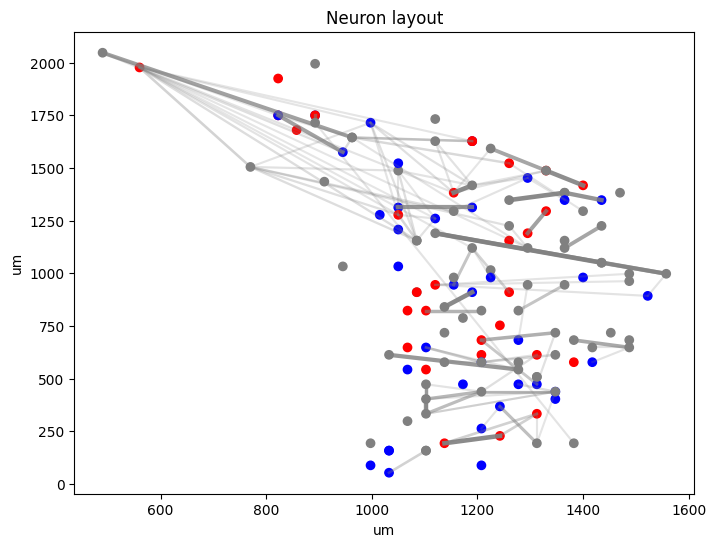

In [34]:
    neuron_x = []
    neuron_y = []
    for neuron in sd.neuron_data[0].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    
    plt.figure(figsize=(8,6))
    plt.scatter(neuron_x, neuron_y,  c=upd_node_info)


    
    threshold = 0.1
    sttc = sd.spike_time_tilings()
    for i in range(sttc.shape[0]):
        for j in range(sttc.shape[1]):
            if i <= j: continue
            if sttc[i,j] < threshold : continue
            ix,iy = sd.neuron_data[0][i]['position']
            jx,jy = sd.neuron_data[0][j]['position']
            linewidth = 1.5 + 2 * (sttc[i, j] - threshold)
            opacity = 0.2 + 0.8 * (sttc[i, j] - threshold)  # Modify opacity based on correlation
            # Plot line between the points with linewidth and opacity
            plt.plot([ix, jx], [iy, jy], linewidth=linewidth, c='grey', alpha=opacity)
    plt.xlabel('um')
    plt.ylabel('um')
    plt.title("Neuron layout")
    

In [28]:
def sttc_neuron_plotter(thresh):
    
    neuron_x = []
    neuron_y = []
    neuron_amp = []
    for neuron in sd.neuron_data[0].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
        neuron_amp.append(np.mean(neuron['amplitudes']))
    neuron_amp = [closest_value(num) for num in neuron_amp]
    
    plt.figure(figsize=(8,6))
    plt.scatter(neuron_x, neuron_y, s=neuron_amp, c=upd_node_info)
    
    threshold = thresh
    sttc = sd.spike_time_tilings()
    for i in range(sttc.shape[0]):
        for j in range(sttc.shape[1]):
            if i <= j: continue
            if sttc[i,j] < threshold : continue
            ix,iy = sd.neuron_data[0][i]['position']
            jx,jy = sd.neuron_data[0][j]['position']
            linewidth = 1.5 + 2 * (sttc[i, j] - threshold)
            opacity = 0.2 + 0.8 * (sttc[i, j] - threshold)  # Modify opacity based on correlation
            # Plot line between the points with linewidth and opacity
            plt.plot([ix, jx], [iy, jy], linewidth=linewidth, c='grey', alpha=opacity)
    plt.xlabel('um')
    plt.ylabel('um')
    plt.title("Neuron layout")
    
    node_degree_legend_elements = [
        plt.scatter([], [], s=5, marker='o', edgecolor='black', facecolor='none', label='5'),
        plt.scatter([], [], s=20, marker='o', edgecolor='black', facecolor='none', label='20'),
        plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='none', label='50')
    ]
    
    node_type_legend_elements = [
        plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='grey', label='Broker'),
        plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='red', label='Sender'),
        plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='blue', label='Receiver')
    ]
    
    node_degree_legend = plt.legend(handles=node_degree_legend_elements, title='Node Degree', loc='lower right')
    plt.gca().add_artist(node_degree_legend)
    
    correlation_legend_elements = [
        plt.Line2D([0], [0], color='grey', linewidth=0.5, label='0.6'),
        plt.Line2D([0], [0], color='grey', linewidth=1.0, label='0.8'),
        plt.Line2D([0], [0], color='grey', linewidth=1.5, label='1.0')
    ]
    
    correlation_legend = plt.legend(handles=correlation_legend_elements, title='Correlation', loc='lower left')
    plt.gca().add_artist(correlation_legend)
    
    node_type_legend = plt.legend(handles=node_type_legend_elements, title='Node Type', loc='best')
    plt.gca().add_artist(node_type_legend)

    plt.show()

/tmp/ipykernel_2118/3357236074.py:6: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():
/tmp/ipykernel_2118/3357236074.py:21: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  ix,iy = sd.neuron_data[0][i]['position']
/tmp/ipykernel_2118/3357236074.py:22: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  jx,jy = sd.neuron_data[0][j]['position']


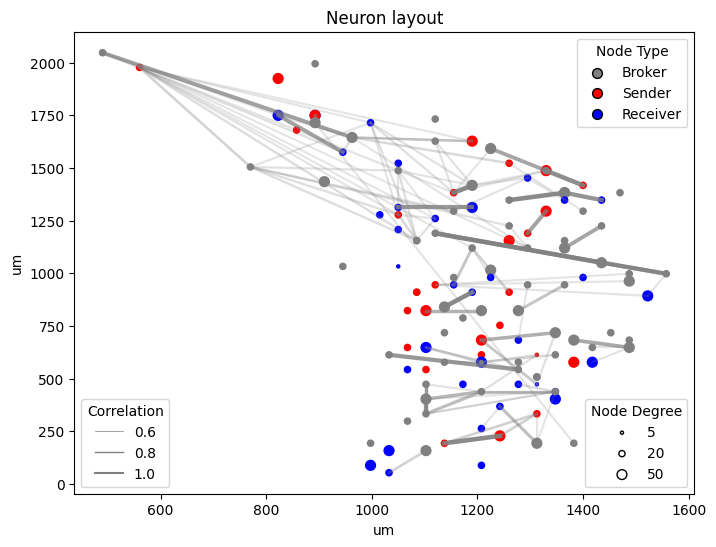

In [31]:
sttc_neuron_plotter(0.1)